In [8]:
import torch
d_model = 1 # number of features for a single "token"
model = torch.nn.Transformer(d_model=d_model, nhead=1)

In [2]:
src = torch.Tensor([1,2,3,4]).reshape((4,1,d_model))
tgt = torch.Tensor([1]).reshape((1,1,d_model))
model(src, tgt)

tensor([[[-3.4650e-11]]], grad_fn=<NativeLayerNormBackward0>)

In [1]:
from utils import load_dataset
mosi = load_dataset(["CMU_MOSI_Visual_Facet_41"])

[2022-01-09 22:36:41.086] | Error   | cmumosi/CMU_MOSI_TimestampedWordVectors.csd file already exists ...
High-level features have been downloaded previously.
[2022-01-09 22:36:41.086] | Error   | cmumosi/CMU_MOSI_TimestampedWords.csd file already exists ...
Raw data have been downloaded previously.
[2022-01-09 22:36:41.086] | Error   | cmumosi/CMU_MOSI_Opinion_Labels.csd file already exists ...
Labels have been downloaded previously.
[2022-01-09 22:36:41.087] | Success | Computational sequence read from file cmumosi/CMU_MOSI_Opinion_Labels.csd ...
[2022-01-09 22:36:41.092] | Status  | Checking the integrity of the <Opinion Segment Labels> computational sequence ...
[2022-01-09 22:36:41.092] | Status  | Checking the format of the data in <Opinion Segment Labels> computational sequence ...


[2022-01-09 22:36:41.132] | Success | <Opinion Segment Labels> computational sequence data in correct format.
[2022-01-09 22:36:41.132] | Status  | Checking the format of the metadata in <Opinion Segment Labels> computational sequence ...
[2022-01-09 22:36:41.132] | Warning | <Opinion Segment Labels> computational sequence does not have all the required metadata ... continuing 
[2022-01-09 22:36:41.133] | Success | Computational sequence read from file cmumosi/CMU_MOSI_Visual_Facet_41.csd ...
[2022-01-09 22:36:41.138] | Status  | Checking the integrity of the <FACET_4.1> computational sequence ...
[2022-01-09 22:36:41.138] | Status  | Checking the format of the data in <FACET_4.1> computational sequence ...


[2022-01-09 22:36:41.175] | Success | <FACET_4.1> computational sequence data in correct format.
[2022-01-09 22:36:41.175] | Status  | Checking the format of the metadata in <FACET_4.1> computational sequence ...
[2022-01-09 22:36:41.175] | Warning | <FACET_4.1> computational sequence does not have all the required metadata ... continuing 
[2022-01-09 22:36:41.175] | Success | Dataset initialized successfully ... 
[2022-01-09 22:36:41.175] | Status  | Unify was called ...
[2022-01-09 22:36:41.175] | Success | Unify completed ...
[2022-01-09 22:36:41.175] | Status  | Pre-alignment based on <CMU_MOSI_Opinion_Labels> computational sequence started ...


[2022-01-09 22:36:41.763] | Status  | Pre-alignment done for <CMU_MOSI_Visual_Facet_41> ...
[2022-01-09 22:36:41.766] | Status  | Alignment starting ...


Aligning 03bSnISJMiM:   0%|          | 0/13 [00:00<?, ? Segments/s]
                                                                   
Aligning 0h-zjBukYpk:   0%|          | 0/25 [00:00<?, ? Segments/s]
                                                                   
Aligning 1DmNV9C1hbY:   0%|          | 0/14 [00:00<?, ? Segments/s]
                                                                   
Aligning 1iG0909rllw:   0%|          | 0/30 [00:00<?, ? Segments/s]
                                                                   
Aligning 2iD-tVS8NPw:   0%|          | 0/30 [00:00<?, ? Segments/s]
                                                                   
Aligning 5W7Z1C_fDaE:   0%|          | 0/24 [00:00<?, ? Segments/s]
                                                                   
Aligning 6Egk_28TtTM:   0%|          | 0/12 [00:00<?, ? Segments/s]
                                                                   
Aligning 6_0THN4chvY:   0%|          | 0/14 [00:

[2022-01-09 22:36:43.377] | Success | Alignment to <CMU_MOSI_Opinion_Labels> complete.
[2022-01-09 22:36:43.377] | Status  | Replacing dataset content with aligned computational sequences
[2022-01-09 22:36:43.379] | Success | Initialized empty <CMU_MOSI_Opinion_Labels> computational sequence.
[2022-01-09 22:36:43.379] | Status  | Checking the format of the data in <CMU_MOSI_Opinion_Labels> computational sequence ...


[2022-01-09 22:36:43.383] | Success | <CMU_MOSI_Opinion_Labels> computational sequence data in correct format.
[2022-01-09 22:36:43.383] | Status  | Checking the format of the metadata in <CMU_MOSI_Opinion_Labels> computational sequence ...
[2022-01-09 22:36:43.383] | Warning | <CMU_MOSI_Opinion_Labels> computational sequence does not have all the required metadata ... continuing 
[2022-01-09 22:36:43.383] | Success | Initialized empty <CMU_MOSI_Visual_Facet_41> computational sequence.
[2022-01-09 22:36:43.383] | Status  | Checking the format of the data in <CMU_MOSI_Visual_Facet_41> computational sequence ...


[2022-01-09 22:36:43.386] | Success | <CMU_MOSI_Visual_Facet_41> computational sequence data in correct format.
[2022-01-09 22:36:43.386] | Status  | Checking the format of the metadata in <CMU_MOSI_Visual_Facet_41> computational sequence ...
[2022-01-09 22:36:43.386] | Warning | <CMU_MOSI_Visual_Facet_41> computational sequence does not have all the required metadata ... continuing 


In [2]:
import torch
train_loader = torch.utils.data.DataLoader(mosi['train'], batch_size=32)
val_loader = torch.utils.data.DataLoader(mosi['val'], batch_size=32)
test_loader = torch.utils.data.DataLoader(mosi['test'], batch_size=32)

In [3]:
model = torch.nn.Sequential(torch.nn.Linear(len(mosi['train'].features)-1, 1, dtype=torch.float64))
model.to('cuda')
optim = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

In [12]:
model.train()
for epoch in range(10):
    running_loss = 0
    for i, batch in enumerate(train_loader):
        optim.zero_grad()

        x = [v for (k,v) in batch.items() if k != "labels"]
        x2 = torch.stack(x)
        x2 = x2.transpose(1,0)
        x2 = x2.to('cuda')

        y_true = batch['labels']
        y_true = y_true.reshape(len(y_true), 1)
        y_true = y_true.double()
        y_true = y_true.to('cuda')

        y_pred = model(x2)

        loss = criterion(y_pred, y_true)
        loss.backward()
        optim.step()

        running_loss += loss.item()
    print(running_loss)

32.7710007328196
30.779835046280052
29.55652066327904
28.847358507780793
28.467651697361028
28.278148279437268
28.186777510884102
28.14195257253029
28.11850893673728
28.10540738439235


In [22]:
model.eval()
corrects = 0
total = 0
for i, batch in enumerate(test_loader):
    x = [v for (k,v) in batch.items() if k != "labels"]
    x2 = torch.stack(x)
    x2 = x2.transpose(1,0)
    x2 = x2.to('cuda')

    y_true = batch['labels']
    y_true = y_true.reshape(len(y_true), 1)
    y_true = y_true.to('cuda')

    y_pred = torch.sigmoid(model(x2))
    y_pred = y_pred.round()

    results = y_true == y_pred
    corrects += sum(results).item()
    total += len(results)
print(corrects / total)

0.5874635568513119


In [196]:
import shap
import shap.plots
omg = mosi['train'].remove_columns('labels').to_pandas()
omg2 = torch.Tensor(omg.to_numpy())

# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html
# "SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function."
def f(X):
    X2 = torch.Tensor(X)
    X2 = X2.to('cuda')
    X2 = X2.double()
    return model(X2).cpu().detach().numpy()

feat_names = [t for t in mosi['train'].features if t != "labels"]

explainer = shap.Explainer(f, omg.to_numpy(), feature_names=feat_names)
# explainer = shap.AdditiveExplainer(f, omg.to_numpy(), feature_names=feat_names)

In [ ]:
[v for (k,v) in next(iter(test_loader)).items() if k != "labels"]

In [ ]:
x = [v for (k,v) in next(iter(test_loader)).items() if k != "labels"]
x2 = torch.stack(x)
x2 = x2.transpose(1,0)
x2 = x2.to('cuda')
print(model(x2))

In [121]:
x2[0].shape

torch.Size([47])

In [205]:
sample = x2[0]
# shap_values = explainer(omg.to_numpy())
shap_values = explainer(sample.reshape(1, len(sample)).cpu().numpy())

tensor([0.2046], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


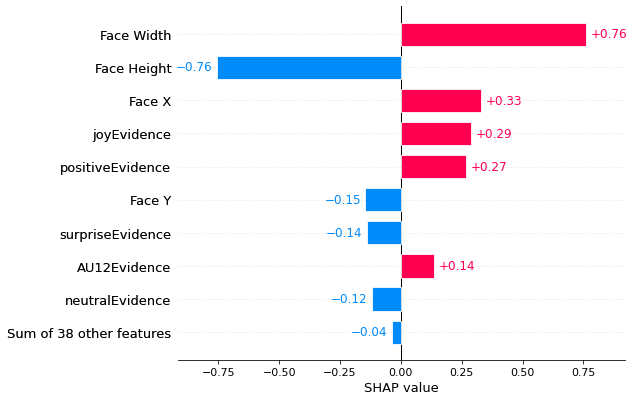

In [206]:
print(model(sample))

# PERMUTATION EXPLAINER
shap.plots.bar(shap_values[0,:])

# ADDITIVE EXPLAINER
# shap.plots.bar(shap_values[0,:,0])
# shap.plots.waterfall(shap_values[0,:,0])

In [165]:
shap_values[0][0].shape

(47,)